<a href="https://colab.research.google.com/github/MuhammadAlBarham/-Atmel-SAM3X8E-ARM-Cortex-M3/blob/master/Full_Project_Image_Classifer_Resnet_18_Testing_Feb_1_8_PM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading Data

In [2]:
# Import neccessary Data 

import torch
import torchvision 
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Subset 

import numpy as np

In [3]:
# check if CUDA is available

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    
device = torch.device("cuda" if train_on_gpu else "cpu")

device 

CUDA is available!  Training on GPU ...


device(type='cuda')

# Dataset overview 

image shape is (64, 64)
image size is 4096
Min pixel value is 29
Max pixel value is 224


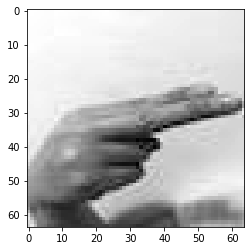

In [8]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline





import cv2

# Load an color image in grayscale
im = cv2.imread('/content/drive/MyDrive/images/ain/AIN (2114).jpg',0)   # Using CV2 , return the image as ndarray 
image0 = Image.open("/content/drive/MyDrive/images/ain/AIN (2114).jpg")    # Using image PIL , return image as <class 'PIL.JpegImagePlugin.JpegImageFile'>


# print(type(im)) # <class 'PIL.JpegImagePlugin.JpegImageFile'>

image = np.asarray(image0)

print('image shape is {}'.format(image.shape)) # We have GrayScale images 
print('image size is {}'.format(im.size,"\n"))

print('Min pixel value is {}'.format(image.min())) 
print('Max pixel value is {}'.format(image.max()))

width, height = image0.size # if you are using PIL 

# print(f"Image's width is {width}",f" \t Image's height is {height}\n")
plt.imshow(im, cmap='gray')

# plt.imshow(np.asarray(im), cmap = 'gray')

In [ ]:
# Test the image's values for the RGB channels 
# 0 is black and 255 is white 
im

array([[224, 224, 224, ..., 207, 207, 207],
       [224, 224, 223, ..., 207, 207, 207],
       [224, 223, 223, ..., 207, 207, 207],
       ...,
       [206, 166, 133, ..., 123, 133, 147],
       [195, 188, 153, ..., 139, 145, 158],
       [189, 205, 170, ..., 154, 156, 166]], dtype=uint8)

In [10]:
# Tesring the return Data Type of ImageFolder 

data_dir = "/content/drive/MyDrive/images"

dataset = torchvision.datasets.ImageFolder(root = data_dir) 

In [11]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=64x64 at 0x7FEB38054CC0>, 0)

# Image Loading + Pre-Processing 

In [ ]:
import sklearn
from sklearn.model_selection import train_test_split

In [ ]:
class MyLazyDataset():
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        if self.transform:
            x = self.transform(dataset[index][0])
        else:
            x = dataset[index][0]
        y = dataset[index][1]
        return x, y
    
    def __len__(self):
        return len(dataset)

In [ ]:
# Parameter Tunning to the network : 

data_dir = "/content/drive/MyDrive/images"


width_size  = 256
height_size = 256

# mean_values, std_values = ( (0.5,0.5,0.5) , (0.5,0.5,0.5) )
mean_values, std_values = ( (0.485, 0.456, 0.406), (0.229, 0.224, 0.225) ) 

num_workers = 0
batch_size = 128


#------------------------------------------------------------------------------------------------------------------------------------------------------------------#
#                                                                                                                                                                  #
#                                                                                                                                                                  #
#                                                                                                                                                                  #                                                                                                                                                  
#                                                                                                                                                                  #
#------------------------------------------------------------------------------------------------------------------------------------------------------------------#


# Transformation 

trans = transforms.Compose([# transforms.RandomRotation(25),
                              transforms.Resize(224),
                            #  transforms.RandomHorizontalFlip(),
                            #transforms.RandomVerticalFlip(0.3),
                              transforms.CenterCrop(224),
                              transforms.ToTensor() ,
                            transforms.Grayscale(num_output_channels=1)
                              #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
 ] )
                            

transNoAugment = transforms.Compose([transforms.Resize(224), 
                                  transforms.CenterCrop(224),
                                  transforms.ToTensor(),
                                  transforms.Grayscale(num_output_channels=1)
                                #  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
])
                                  
#torchvision.transforms.Grayscale(num_output_channels=1)

#--------------------------------------------------------------------------------------------------------

# Load the images 

dataset = torchvision.datasets.ImageFolder(root = data_dir) 



traindataset = MyLazyDataset(dataset,trans)
testdataset = MyLazyDataset(dataset,transNoAugment)


num_train = len(dataset)
indices = list(range(num_train))

print(num_train)


X_train, X_test, _, _ = train_test_split(indices, indices, test_size=0.1, random_state=42)

# trian_test_split from sikit_learn 

traindata = torch.utils.data.Subset(traindataset, indices=X_train)
# valdata = torch.utils.data.Subset(valdataset, indices=valid_idx)
testdata = torch.utils.data.Subset(testdataset, indices=X_test)

#-----------------------------------------------------------------------------------------------------------------------

# Define samplers for obtaining training and testing
# Samples elements randomly from a given list of indices, without replacement.

#train_sampler = SubsetRandomSampler(train_idx)
#test_sampler  = SubsetRandomSampler(test_idx)


# Prepare the loader of the data

train_loader = torch.utils.data.DataLoader(traindata, batch_size=batch_size, 
                                          num_workers=num_workers)
#valLoader = torch.utils.data.DataLoader(valdata, batch_size=batch_size, 
#                                         num_workers=num_workers, drop_last=True)
test_loader = torch.utils.data.DataLoader(testdata, batch_size=batch_size,
                                          num_workers=num_workers)

print("train_loader type is {}".format(type(train_loader)) , "\n")


# --------------------------------------------------------------------------------------------------------------------------------

print(f"train_loader size is {len(train_loader)}")
#print(f"val_Loader size is {len(valLoader)}")
print(f"test_Loader  size is {len(test_loader)}")




57353
train_loader type is torch.utils.data.dataloader.DataLoader 

train_loader size is 404
test_Loader  size is 45


In [ ]:
dataiter = iter(test_loader)

print(type(test_loader))

tensor_image, labels = dataiter.next()

print(tensor_image.shape)

torch.utils.data.dataloader.DataLoader
torch.Size([128, 1, 224, 224])


In [ ]:
dataiter = iter(train_loader)

print(type(train_loader))

tensor_image, labels = dataiter.next()

print(tensor_image.shape)

torch.utils.data.dataloader.DataLoader
torch.Size([128, 1, 224, 224])


[link text](https://)# Define a Convolutional Neural Network

In [ ]:
import torchvision.models as models
resnet18 = models.resnet18(pretrained=True)
resnet18

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:

import torch.nn as nn
import torch.nn.functional as F


num_ftrs = resnet18.fc.in_features

resnet18.fc = nn.Linear(num_ftrs, 32)



In [ ]:
#resnet18

In [ ]:
class MyModule(nn.Module):
  def __init__(self, output_size):
    super().__init__()
    self.first = torch.nn.Sequential(*list(resnet18.children())[0:3])
    self.first[0] = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

    self.second = torch.nn.Sequential(*list(resnet18.children())[4:-2])
    self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
    self.output = nn.Linear(512, output_size)
  def forward(self, x):
    x = self.first(x)
    out = self.second(x)
    avg = self.avgpool(out)

    output = self.output(avg.view(avg.shape[0], -1))
    return output

model = MyModule(32)

# new_base =   + (list(resnet18.children()))[4:]
# new_base[0] = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
# new_base = torch.nn.Sequential(*new_base)
# #new_base[0][1].conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

#new_base.to(device)
# #print(new_base[0])

In [ ]:
#x = torch.randn(6,3,56,56)
#model(x).shape

In [ ]:
model.to(device)

MyModule(
  (first): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (second): Sequential(
    (0): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv

# Define a Loss function and optimizer

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
#from tqdm import tqdm
from tqdm.notebook import tqdm


In [ ]:
# model.load_state_dict(torch.load('/content/drive/MyDrive/cifar_net_4.pth'))
# model.to(device)

# Train the network

In [ ]:
accuracy = 0

for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    
    model.train()
    for i, data in tqdm(enumerate(train_loader, 0),"Epoch # is {}".format(epoch) ,total = len(train_loader)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics 
        running_loss += loss.item()
        if i % 10 == 0:    # print every 2000 mini-batches
            print('[%d, %d] Training loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for data in tqdm(test_loader, total = len(test_loader)):
            images, labels = data

            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on test images: %f %%' % (
        100 * correct / total)) 
    if (100 * correct / total) > accuracy : 
      accuracy = 100* correct / total
      PATH = '/content/drive/MyDrive/Vertical_Model.pth'
      torch.save(model.state_dict(), PATH)
    print(f" The best accuracy is {accuracy}")

print('Finished Training')

[1, 1] Training loss: 0.364
[1, 11] Training loss: 4.559
[1, 21] Training loss: 3.722
[1, 31] Training loss: 3.542
[1, 41] Training loss: 3.551
[1, 51] Training loss: 3.524
[1, 61] Training loss: 3.528
[1, 71] Training loss: 3.515
[1, 81] Training loss: 3.469
[1, 91] Training loss: 3.470
[1, 101] Training loss: 3.455
[1, 111] Training loss: 3.444
[1, 121] Training loss: 3.414
[1, 131] Training loss: 3.418
[1, 141] Training loss: 3.377
[1, 151] Training loss: 3.339
[1, 161] Training loss: 3.305
[1, 171] Training loss: 3.151
[1, 181] Training loss: 3.072
[1, 191] Training loss: 2.952
[1, 201] Training loss: 2.918
[1, 211] Training loss: 2.748
[1, 221] Training loss: 2.651
[1, 231] Training loss: 2.521
[1, 241] Training loss: 2.362
[1, 251] Training loss: 2.309
[1, 261] Training loss: 2.152
[1, 271] Training loss: 2.098
[1, 281] Training loss: 1.935
[1, 291] Training loss: 1.810
[1, 301] Training loss: 1.637
[1, 311] Training loss: 1.549
[1, 321] Training loss: 1.497
[1, 331] Training los


Accuracy of the network on test images: 60.373082 %
 The best accuracy is 60.37308228730823


[2, 1] Training loss: 0.069
[2, 11] Training loss: 0.734
[2, 21] Training loss: 0.657
[2, 31] Training loss: 0.684
[2, 41] Training loss: 0.660
[2, 51] Training loss: 0.602
[2, 61] Training loss: 0.620
[2, 71] Training loss: 0.580
[2, 81] Training loss: 0.455
[2, 91] Training loss: 0.431
[2, 101] Training loss: 0.432
[2, 111] Training loss: 0.484
[2, 121] Training loss: 0.460
[2, 131] Training loss: 0.438
[2, 141] Training loss: 0.407
[2, 151] Training loss: 0.427
[2, 161] Training loss: 0.404
[2, 171] Training loss: 0.385
[2, 181] Training loss: 0.413
[2, 191] Training loss: 0.358
[2, 201] Training loss: 0.387
[2, 211] Training loss: 0.335
[2, 221] Training loss: 0.327
[2, 231] Training loss: 0.315
[2, 241] Training loss: 0.255
[2, 251] Training loss: 0.327
[2, 261] Training loss: 0.271
[2, 271] Training loss: 0.293
[2, 281] Training loss: 0.258
[2, 291] Training loss: 0.237
[2, 301] Training loss: 0.226
[2, 311] Training loss: 0.232
[2, 321] Training loss: 0.244
[2, 331] Training los


Accuracy of the network on test images: 87.360530 %
 The best accuracy is 87.360529986053


[3, 1] Training loss: 0.017
[3, 11] Training loss: 0.242
[3, 21] Training loss: 0.206
[3, 31] Training loss: 0.207
[3, 41] Training loss: 0.198
[3, 51] Training loss: 0.205
[3, 61] Training loss: 0.181
[3, 71] Training loss: 0.199
[3, 81] Training loss: 0.157
[3, 91] Training loss: 0.224
[3, 101] Training loss: 0.213
[3, 111] Training loss: 0.212
[3, 121] Training loss: 0.180
[3, 131] Training loss: 0.205
[3, 141] Training loss: 0.208
[3, 151] Training loss: 0.225
[3, 161] Training loss: 0.212
[3, 171] Training loss: 0.207
[3, 181] Training loss: 0.200
[3, 191] Training loss: 0.173
[3, 201] Training loss: 0.208
[3, 211] Training loss: 0.179
[3, 221] Training loss: 0.176
[3, 231] Training loss: 0.189
[3, 241] Training loss: 0.169
[3, 251] Training loss: 0.167
[3, 261] Training loss: 0.162
[3, 271] Training loss: 0.186
[3, 281] Training loss: 0.157
[3, 291] Training loss: 0.151
[3, 301] Training loss: 0.162
[3, 311] Training loss: 0.162
[3, 321] Training loss: 0.171
[3, 331] Training los


Accuracy of the network on test images: 91.300558 %
 The best accuracy is 91.30055788005579


[4, 1] Training loss: 0.010
[4, 11] Training loss: 0.154
[4, 21] Training loss: 0.144
[4, 31] Training loss: 0.148
[4, 41] Training loss: 0.156
[4, 51] Training loss: 0.162
[4, 61] Training loss: 0.148
[4, 71] Training loss: 0.168
[4, 81] Training loss: 0.133
[4, 91] Training loss: 0.182
[4, 101] Training loss: 0.144
[4, 111] Training loss: 0.134
[4, 121] Training loss: 0.144
[4, 131] Training loss: 0.162
[4, 141] Training loss: 0.180
[4, 151] Training loss: 0.191
[4, 161] Training loss: 0.151
[4, 171] Training loss: 0.168
[4, 181] Training loss: 0.187
[4, 191] Training loss: 0.151
[4, 201] Training loss: 0.175
[4, 211] Training loss: 0.144
[4, 221] Training loss: 0.141
[4, 231] Training loss: 0.151
[4, 241] Training loss: 0.127
[4, 251] Training loss: 0.135
[4, 261] Training loss: 0.137
[4, 271] Training loss: 0.152
[4, 281] Training loss: 0.129
[4, 291] Training loss: 0.119
[4, 301] Training loss: 0.144
[4, 311] Training loss: 0.145
[4, 321] Training loss: 0.140
[4, 331] Training los


Accuracy of the network on test images: 92.050209 %
 The best accuracy is 92.05020920502092


[5, 1] Training loss: 0.007
[5, 11] Training loss: 0.135
[5, 21] Training loss: 0.120
[5, 31] Training loss: 0.123
[5, 41] Training loss: 0.144
[5, 51] Training loss: 0.138
[5, 61] Training loss: 0.128
[5, 71] Training loss: 0.153
[5, 81] Training loss: 0.120
[5, 91] Training loss: 0.149
[5, 101] Training loss: 0.134
[5, 111] Training loss: 0.121
[5, 121] Training loss: 0.110
[5, 131] Training loss: 0.129
[5, 141] Training loss: 0.121
[5, 151] Training loss: 0.134
[5, 161] Training loss: 0.128
[5, 171] Training loss: 0.141
[5, 181] Training loss: 0.162
[5, 191] Training loss: 0.123
[5, 201] Training loss: 0.175
[5, 211] Training loss: 0.149
[5, 221] Training loss: 0.141
[5, 231] Training loss: 0.136
[5, 241] Training loss: 0.132
[5, 251] Training loss: 0.127
[5, 261] Training loss: 0.138
[5, 271] Training loss: 0.147
[5, 281] Training loss: 0.150
[5, 291] Training loss: 0.131
[5, 301] Training loss: 0.127
[5, 311] Training loss: 0.138
[5, 321] Training loss: 0.152
[5, 331] Training los


Accuracy of the network on test images: 92.555788 %
 The best accuracy is 92.5557880055788


[6, 1] Training loss: 0.010
[6, 11] Training loss: 0.136
[6, 21] Training loss: 0.121
[6, 31] Training loss: 0.115
[6, 41] Training loss: 0.134
[6, 51] Training loss: 0.127
[6, 61] Training loss: 0.117
[6, 71] Training loss: 0.134
[6, 81] Training loss: 0.116
[6, 91] Training loss: 0.143
[6, 101] Training loss: 0.123
[6, 111] Training loss: 0.112
[6, 121] Training loss: 0.106
[6, 131] Training loss: 0.111
[6, 141] Training loss: 0.116
[6, 151] Training loss: 0.122
[6, 161] Training loss: 0.117
[6, 171] Training loss: 0.126
[6, 181] Training loss: 0.138
[6, 191] Training loss: 0.118
[6, 201] Training loss: 0.127
[6, 211] Training loss: 0.120
[6, 221] Training loss: 0.121
[6, 231] Training loss: 0.123
[6, 241] Training loss: 0.105
[6, 251] Training loss: 0.115
[6, 261] Training loss: 0.121
[6, 271] Training loss: 0.122
[6, 281] Training loss: 0.115
[6, 291] Training loss: 0.100
[6, 301] Training loss: 0.117
[6, 311] Training loss: 0.114
[6, 321] Training loss: 0.110
[6, 331] Training los


Accuracy of the network on test images: 92.503487 %
 The best accuracy is 92.5557880055788


[7, 1] Training loss: 0.007
[7, 11] Training loss: 0.111
[7, 21] Training loss: 0.104
[7, 31] Training loss: 0.106
[7, 41] Training loss: 0.109
[7, 51] Training loss: 0.118
[7, 61] Training loss: 0.132
[7, 71] Training loss: 0.148
[7, 81] Training loss: 0.137
[7, 91] Training loss: 0.151
[7, 101] Training loss: 0.131
[7, 111] Training loss: 0.137
[7, 121] Training loss: 0.117
[7, 131] Training loss: 0.138
[7, 141] Training loss: 0.135
[7, 151] Training loss: 0.128
[7, 161] Training loss: 0.132
[7, 171] Training loss: 0.133
[7, 181] Training loss: 0.170
[7, 191] Training loss: 0.134
[7, 201] Training loss: 0.148
[7, 211] Training loss: 0.133
[7, 221] Training loss: 0.140
[7, 231] Training loss: 0.136
[7, 241] Training loss: 0.124
[7, 251] Training loss: 0.124
[7, 261] Training loss: 0.127
[7, 271] Training loss: 0.114
[7, 281] Training loss: 0.110
[7, 291] Training loss: 0.099
[7, 301] Training loss: 0.117
[7, 311] Training loss: 0.117
[7, 321] Training loss: 0.117
[7, 331] Training los


Accuracy of the network on test images: 91.126220 %
 The best accuracy is 92.5557880055788


[8, 1] Training loss: 0.006
[8, 11] Training loss: 0.147
[8, 21] Training loss: 0.125
[8, 31] Training loss: 0.117
[8, 41] Training loss: 0.132
[8, 51] Training loss: 0.121
[8, 61] Training loss: 0.113
[8, 71] Training loss: 0.122
[8, 81] Training loss: 0.101
[8, 91] Training loss: 0.127
[8, 101] Training loss: 0.120
[8, 111] Training loss: 0.115
[8, 121] Training loss: 0.103
[8, 131] Training loss: 0.109
[8, 141] Training loss: 0.107
[8, 151] Training loss: 0.114
[8, 161] Training loss: 0.103
[8, 171] Training loss: 0.131
[8, 181] Training loss: 0.140
[8, 191] Training loss: 0.112
[8, 201] Training loss: 0.128
[8, 211] Training loss: 0.111
[8, 221] Training loss: 0.107
[8, 231] Training loss: 0.111
[8, 241] Training loss: 0.105
[8, 251] Training loss: 0.099
[8, 261] Training loss: 0.108
[8, 271] Training loss: 0.114
[8, 281] Training loss: 0.112
[8, 291] Training loss: 0.099
[8, 301] Training loss: 0.117
[8, 311] Training loss: 0.124
[8, 321] Training loss: 0.115
[8, 331] Training los


Accuracy of the network on test images: 89.400279 %
 The best accuracy is 92.5557880055788


[9, 1] Training loss: 0.007
[9, 11] Training loss: 0.134
[9, 21] Training loss: 0.120
[9, 31] Training loss: 0.145
[9, 41] Training loss: 0.132
[9, 51] Training loss: 0.141
[9, 61] Training loss: 0.124
[9, 71] Training loss: 0.125
[9, 81] Training loss: 0.107
[9, 91] Training loss: 0.146
[9, 101] Training loss: 0.129
[9, 111] Training loss: 0.113
[9, 121] Training loss: 0.096
[9, 131] Training loss: 0.103
[9, 141] Training loss: 0.103
[9, 151] Training loss: 0.124
[9, 161] Training loss: 0.106
[9, 171] Training loss: 0.120
[9, 181] Training loss: 0.135
[9, 191] Training loss: 0.119
[9, 201] Training loss: 0.156
[9, 211] Training loss: 0.154
[9, 221] Training loss: 0.128
[9, 231] Training loss: 0.130
[9, 241] Training loss: 0.113
[9, 251] Training loss: 0.106
[9, 261] Training loss: 0.125
[9, 271] Training loss: 0.109
[9, 281] Training loss: 0.115
[9, 291] Training loss: 0.091
[9, 301] Training loss: 0.109
[9, 311] Training loss: 0.109
[9, 321] Training loss: 0.111
[9, 331] Training los


Accuracy of the network on test images: 92.189679 %
 The best accuracy is 92.5557880055788


[10, 1] Training loss: 0.005
[10, 11] Training loss: 0.119
[10, 21] Training loss: 0.101
[10, 31] Training loss: 0.109
[10, 41] Training loss: 0.116
[10, 51] Training loss: 0.115
[10, 61] Training loss: 0.119
[10, 71] Training loss: 0.115
[10, 81] Training loss: 0.102
[10, 91] Training loss: 0.110
[10, 101] Training loss: 0.116
[10, 111] Training loss: 0.104
[10, 121] Training loss: 0.093
[10, 131] Training loss: 0.097
[10, 141] Training loss: 0.095
[10, 151] Training loss: 0.098
[10, 161] Training loss: 0.094
[10, 171] Training loss: 0.097
[10, 181] Training loss: 0.112
[10, 191] Training loss: 0.096
[10, 201] Training loss: 0.107
[10, 211] Training loss: 0.097
[10, 221] Training loss: 0.097
[10, 231] Training loss: 0.096
[10, 241] Training loss: 0.089
[10, 251] Training loss: 0.095
[10, 261] Training loss: 0.099
[10, 271] Training loss: 0.097
[10, 281] Training loss: 0.099
[10, 291] Training loss: 0.087
[10, 301] Training loss: 0.102
[10, 311] Training loss: 0.101
[10, 321] Training 


Accuracy of the network on test images: 93.479777 %
 The best accuracy is 93.47977684797769


[11, 1] Training loss: 0.005
[11, 11] Training loss: 0.108
[11, 21] Training loss: 0.098
[11, 31] Training loss: 0.098
[11, 41] Training loss: 0.107
[11, 51] Training loss: 0.102
[11, 61] Training loss: 0.098
[11, 71] Training loss: 0.100
[11, 81] Training loss: 0.089
[11, 91] Training loss: 0.101
[11, 101] Training loss: 0.100
[11, 111] Training loss: 0.089
[11, 121] Training loss: 0.082
[11, 131] Training loss: 0.089
[11, 141] Training loss: 0.094
[11, 151] Training loss: 0.100
[11, 161] Training loss: 0.092
[11, 171] Training loss: 0.101
[11, 181] Training loss: 0.115
[11, 191] Training loss: 0.092
[11, 201] Training loss: 0.108
[11, 211] Training loss: 0.111
[11, 221] Training loss: 0.108
[11, 231] Training loss: 0.117
[11, 241] Training loss: 0.115
[11, 251] Training loss: 0.129
[11, 261] Training loss: 0.154
[11, 271] Training loss: 0.122
[11, 281] Training loss: 0.139
[11, 291] Training loss: 0.119
[11, 301] Training loss: 0.115
[11, 311] Training loss: 0.121
[11, 321] Training 


Accuracy of the network on test images: 91.997908 %
 The best accuracy is 93.47977684797769


[12, 1] Training loss: 0.006
[12, 11] Training loss: 0.132
[12, 21] Training loss: 0.126
[12, 31] Training loss: 0.127
[12, 41] Training loss: 0.130
[12, 51] Training loss: 0.123
[12, 61] Training loss: 0.118
[12, 71] Training loss: 0.111
[12, 81] Training loss: 0.096
[12, 91] Training loss: 0.116
[12, 101] Training loss: 0.111
[12, 111] Training loss: 0.099
[12, 121] Training loss: 0.087
[12, 131] Training loss: 0.098
[12, 141] Training loss: 0.096
[12, 151] Training loss: 0.108
[12, 161] Training loss: 0.108
[12, 171] Training loss: 0.101
[12, 181] Training loss: 0.107
[12, 191] Training loss: 0.107
[12, 201] Training loss: 0.114
[12, 211] Training loss: 0.111
[12, 221] Training loss: 0.105
[12, 231] Training loss: 0.102
[12, 241] Training loss: 0.096
[12, 251] Training loss: 0.105
[12, 261] Training loss: 0.105
[12, 271] Training loss: 0.106
[12, 281] Training loss: 0.112
[12, 291] Training loss: 0.090
[12, 301] Training loss: 0.103
[12, 311] Training loss: 0.103
[12, 321] Training 


Accuracy of the network on test images: 92.817294 %
 The best accuracy is 93.47977684797769


[13, 1] Training loss: 0.008
[13, 11] Training loss: 0.106
[13, 21] Training loss: 0.096
[13, 31] Training loss: 0.097
[13, 41] Training loss: 0.107
[13, 51] Training loss: 0.110
[13, 61] Training loss: 0.111
[13, 71] Training loss: 0.121
[13, 81] Training loss: 0.092
[13, 91] Training loss: 0.108
[13, 101] Training loss: 0.112
[13, 111] Training loss: 0.110
[13, 121] Training loss: 0.112
[13, 131] Training loss: 0.107
[13, 141] Training loss: 0.117
[13, 151] Training loss: 0.109
[13, 161] Training loss: 0.115
[13, 171] Training loss: 0.125
[13, 181] Training loss: 0.124
[13, 191] Training loss: 0.100
[13, 201] Training loss: 0.109
[13, 211] Training loss: 0.106
[13, 221] Training loss: 0.103
[13, 231] Training loss: 0.104
[13, 241] Training loss: 0.097
[13, 251] Training loss: 0.103
[13, 261] Training loss: 0.101
[13, 271] Training loss: 0.093
[13, 281] Training loss: 0.101
[13, 291] Training loss: 0.091
[13, 301] Training loss: 0.100
[13, 311] Training loss: 0.100
[13, 321] Training 


Accuracy of the network on test images: 91.335425 %
 The best accuracy is 93.47977684797769


[14, 1] Training loss: 0.006
[14, 11] Training loss: 0.115
[14, 21] Training loss: 0.104
[14, 31] Training loss: 0.091
[14, 41] Training loss: 0.107
[14, 51] Training loss: 0.112
[14, 61] Training loss: 0.101
[14, 71] Training loss: 0.112
[14, 81] Training loss: 0.105
[14, 91] Training loss: 0.118
[14, 101] Training loss: 0.109
[14, 111] Training loss: 0.094
[14, 121] Training loss: 0.084
[14, 131] Training loss: 0.103
[14, 141] Training loss: 0.092
[14, 151] Training loss: 0.095
[14, 161] Training loss: 0.090
[14, 171] Training loss: 0.088
[14, 181] Training loss: 0.100
[14, 191] Training loss: 0.091
[14, 201] Training loss: 0.096
[14, 211] Training loss: 0.093
[14, 221] Training loss: 0.093
[14, 231] Training loss: 0.100
[14, 241] Training loss: 0.088
[14, 251] Training loss: 0.097
[14, 261] Training loss: 0.099
[14, 271] Training loss: 0.088
[14, 281] Training loss: 0.101
[14, 291] Training loss: 0.084
[14, 301] Training loss: 0.111
[14, 311] Training loss: 0.118
[14, 321] Training 


Accuracy of the network on test images: 92.416318 %
 The best accuracy is 93.47977684797769


[15, 1] Training loss: 0.005
[15, 11] Training loss: 0.102
[15, 21] Training loss: 0.102
[15, 31] Training loss: 0.086
[15, 41] Training loss: 0.096
[15, 51] Training loss: 0.101
[15, 61] Training loss: 0.110
[15, 71] Training loss: 0.109
[15, 81] Training loss: 0.105
[15, 91] Training loss: 0.122
[15, 101] Training loss: 0.106
[15, 111] Training loss: 0.105
[15, 121] Training loss: 0.084
[15, 131] Training loss: 0.091
[15, 141] Training loss: 0.094
[15, 151] Training loss: 0.097
[15, 161] Training loss: 0.093
[15, 171] Training loss: 0.094
[15, 181] Training loss: 0.107
[15, 191] Training loss: 0.093
[15, 201] Training loss: 0.099
[15, 211] Training loss: 0.104
[15, 221] Training loss: 0.101
[15, 231] Training loss: 0.107
[15, 241] Training loss: 0.106
[15, 251] Training loss: 0.108
[15, 261] Training loss: 0.107
[15, 271] Training loss: 0.098
[15, 281] Training loss: 0.103
[15, 291] Training loss: 0.093
[15, 301] Training loss: 0.099
[15, 311] Training loss: 0.101
[15, 321] Training 


Accuracy of the network on test images: 91.248257 %
 The best accuracy is 93.47977684797769


[16, 1] Training loss: 0.012
[16, 11] Training loss: 0.102
[16, 21] Training loss: 0.108
[16, 31] Training loss: 0.090
[16, 41] Training loss: 0.104
[16, 51] Training loss: 0.105
[16, 61] Training loss: 0.102
[16, 71] Training loss: 0.109
[16, 81] Training loss: 0.089
[16, 91] Training loss: 0.125
[16, 101] Training loss: 0.112
[16, 111] Training loss: 0.105
[16, 121] Training loss: 0.084
[16, 131] Training loss: 0.101
[16, 141] Training loss: 0.099
[16, 151] Training loss: 0.135
[16, 161] Training loss: 0.145
[16, 171] Training loss: 0.122
[16, 181] Training loss: 0.129
[16, 191] Training loss: 0.112
[16, 201] Training loss: 0.129
[16, 211] Training loss: 0.132
[16, 221] Training loss: 0.121
[16, 231] Training loss: 0.103
[16, 241] Training loss: 0.093
[16, 251] Training loss: 0.107
[16, 261] Training loss: 0.104
[16, 271] Training loss: 0.096
[16, 281] Training loss: 0.097
[16, 291] Training loss: 0.082
[16, 301] Training loss: 0.091
[16, 311] Training loss: 0.096
[16, 321] Training 


Accuracy of the network on test images: 93.253138 %
 The best accuracy is 93.47977684797769


[17, 1] Training loss: 0.005
[17, 11] Training loss: 0.100
[17, 21] Training loss: 0.092
[17, 31] Training loss: 0.088
[17, 41] Training loss: 0.091
[17, 51] Training loss: 0.104
[17, 61] Training loss: 0.098
[17, 71] Training loss: 0.096
[17, 81] Training loss: 0.086
[17, 91] Training loss: 0.091
[17, 101] Training loss: 0.102
[17, 111] Training loss: 0.085
[17, 121] Training loss: 0.079
[17, 131] Training loss: 0.088
[17, 141] Training loss: 0.090
[17, 151] Training loss: 0.085
[17, 161] Training loss: 0.089
[17, 171] Training loss: 0.087
[17, 181] Training loss: 0.100
[17, 191] Training loss: 0.089
[17, 201] Training loss: 0.092
[17, 211] Training loss: 0.093
[17, 221] Training loss: 0.092
[17, 231] Training loss: 0.103
[17, 241] Training loss: 0.088
[17, 251] Training loss: 0.097
[17, 261] Training loss: 0.098
[17, 271] Training loss: 0.090
[17, 281] Training loss: 0.096
[17, 291] Training loss: 0.081
[17, 301] Training loss: 0.092
[17, 311] Training loss: 0.088
[17, 321] Training 


Accuracy of the network on test images: 89.731520 %
 The best accuracy is 93.47977684797769


[18, 1] Training loss: 0.010
[18, 11] Training loss: 0.129
[18, 21] Training loss: 0.106
[18, 31] Training loss: 0.120
[18, 41] Training loss: 0.133
[18, 51] Training loss: 0.158
[18, 61] Training loss: 0.129
[18, 71] Training loss: 0.154
[18, 81] Training loss: 0.145
[18, 91] Training loss: 0.148
[18, 101] Training loss: 0.126
[18, 111] Training loss: 0.106
[18, 121] Training loss: 0.098
[18, 131] Training loss: 0.107
[18, 141] Training loss: 0.090
[18, 151] Training loss: 0.096
[18, 161] Training loss: 0.095
[18, 171] Training loss: 0.090
[18, 181] Training loss: 0.108
[18, 191] Training loss: 0.091
[18, 201] Training loss: 0.111
[18, 211] Training loss: 0.093
[18, 221] Training loss: 0.101
[18, 231] Training loss: 0.102
[18, 241] Training loss: 0.099
[18, 251] Training loss: 0.100
[18, 261] Training loss: 0.102
[18, 271] Training loss: 0.091
[18, 281] Training loss: 0.091
[18, 291] Training loss: 0.083
[18, 301] Training loss: 0.096
[18, 311] Training loss: 0.097
[18, 321] Training 


Accuracy of the network on test images: 93.322873 %
 The best accuracy is 93.47977684797769


[19, 1] Training loss: 0.005
[19, 11] Training loss: 0.117
[19, 21] Training loss: 0.090
[19, 31] Training loss: 0.091
[19, 41] Training loss: 0.112
[19, 51] Training loss: 0.098
[19, 61] Training loss: 0.098
[19, 71] Training loss: 0.100
[19, 81] Training loss: 0.079
[19, 91] Training loss: 0.099
[19, 101] Training loss: 0.101
[19, 111] Training loss: 0.089
[19, 121] Training loss: 0.082
[19, 131] Training loss: 0.095
[19, 141] Training loss: 0.085
[19, 151] Training loss: 0.098
[19, 161] Training loss: 0.088
[19, 171] Training loss: 0.089
[19, 181] Training loss: 0.100
[19, 191] Training loss: 0.089
[19, 201] Training loss: 0.093
[19, 211] Training loss: 0.095
[19, 221] Training loss: 0.096
[19, 231] Training loss: 0.100
[19, 241] Training loss: 0.086
[19, 251] Training loss: 0.110
[19, 261] Training loss: 0.100
[19, 271] Training loss: 0.108
[19, 281] Training loss: 0.097
[19, 291] Training loss: 0.090
[19, 301] Training loss: 0.102
[19, 311] Training loss: 0.099
[19, 321] Training 


Accuracy of the network on test images: 92.974198 %
 The best accuracy is 93.47977684797769


[20, 1] Training loss: 0.005
[20, 11] Training loss: 0.104
[20, 21] Training loss: 0.097
[20, 31] Training loss: 0.097
[20, 41] Training loss: 0.108
[20, 51] Training loss: 0.111
[20, 61] Training loss: 0.109
[20, 71] Training loss: 0.118
[20, 81] Training loss: 0.096
[20, 91] Training loss: 0.122
[20, 101] Training loss: 0.117
[20, 111] Training loss: 0.096
[20, 121] Training loss: 0.084
[20, 131] Training loss: 0.101
[20, 141] Training loss: 0.103
[20, 151] Training loss: 0.099
[20, 161] Training loss: 0.090
[20, 171] Training loss: 0.085
[20, 181] Training loss: 0.095
[20, 191] Training loss: 0.091
[20, 201] Training loss: 0.094
[20, 211] Training loss: 0.094
[20, 221] Training loss: 0.095
[20, 231] Training loss: 0.099
[20, 241] Training loss: 0.083
[20, 251] Training loss: 0.103
[20, 261] Training loss: 0.097
[20, 271] Training loss: 0.085
[20, 281] Training loss: 0.094
[20, 291] Training loss: 0.079
[20, 301] Training loss: 0.090
[20, 311] Training loss: 0.093
[20, 321] Training 


Accuracy of the network on test images: 93.584379 %
 The best accuracy is 93.58437935843794


[21, 1] Training loss: 0.005
[21, 11] Training loss: 0.094
[21, 21] Training loss: 0.088
[21, 31] Training loss: 0.083
[21, 41] Training loss: 0.084
[21, 51] Training loss: 0.091
[21, 61] Training loss: 0.095
[21, 71] Training loss: 0.096
[21, 81] Training loss: 0.076
[21, 91] Training loss: 0.090
[21, 101] Training loss: 0.097
[21, 111] Training loss: 0.082
[21, 121] Training loss: 0.080
[21, 131] Training loss: 0.086
[21, 141] Training loss: 0.084
[21, 151] Training loss: 0.085
[21, 161] Training loss: 0.083
[21, 171] Training loss: 0.084
[21, 181] Training loss: 0.092
[21, 191] Training loss: 0.086
[21, 201] Training loss: 0.086
[21, 211] Training loss: 0.088
[21, 221] Training loss: 0.089
[21, 231] Training loss: 0.092
[21, 241] Training loss: 0.100
[21, 251] Training loss: 0.208
[21, 261] Training loss: 0.200
[21, 271] Training loss: 0.160
[21, 281] Training loss: 0.151
[21, 291] Training loss: 0.121
[21, 301] Training loss: 0.113
[21, 311] Training loss: 0.114
[21, 321] Training 


Accuracy of the network on test images: 92.625523 %
 The best accuracy is 93.58437935843794


[22, 1] Training loss: 0.005
[22, 11] Training loss: 0.108
[22, 21] Training loss: 0.100
[22, 31] Training loss: 0.086
[22, 41] Training loss: 0.098
[22, 51] Training loss: 0.096
[22, 61] Training loss: 0.100
[22, 71] Training loss: 0.095
[22, 81] Training loss: 0.080
[22, 91] Training loss: 0.088
[22, 101] Training loss: 0.097
[22, 111] Training loss: 0.083
[22, 121] Training loss: 0.077
[22, 131] Training loss: 0.087
[22, 141] Training loss: 0.082
[22, 151] Training loss: 0.086
[22, 161] Training loss: 0.082
[22, 171] Training loss: 0.093
[22, 181] Training loss: 0.097
[22, 191] Training loss: 0.084
[22, 201] Training loss: 0.098
[22, 211] Training loss: 0.098
[22, 221] Training loss: 0.093
[22, 231] Training loss: 0.108
[22, 241] Training loss: 0.098
[22, 251] Training loss: 0.106
[22, 261] Training loss: 0.105
[22, 271] Training loss: 0.090
[22, 281] Training loss: 0.093
[22, 291] Training loss: 0.082
[22, 301] Training loss: 0.093
[22, 311] Training loss: 0.089
[22, 321] Training 


Accuracy of the network on test images: 93.218271 %
 The best accuracy is 93.58437935843794


[23, 1] Training loss: 0.005
[23, 11] Training loss: 0.098
[23, 21] Training loss: 0.089
[23, 31] Training loss: 0.089
[23, 41] Training loss: 0.105
[23, 51] Training loss: 0.116
[23, 61] Training loss: 0.121
[23, 71] Training loss: 0.108
[23, 81] Training loss: 0.099
[23, 91] Training loss: 0.103
[23, 101] Training loss: 0.099
[23, 111] Training loss: 0.088
[23, 121] Training loss: 0.080
[23, 131] Training loss: 0.089
[23, 141] Training loss: 0.092
[23, 151] Training loss: 0.089
[23, 161] Training loss: 0.082
[23, 171] Training loss: 0.087
[23, 181] Training loss: 0.098
[23, 191] Training loss: 0.106
[23, 201] Training loss: 0.099
[23, 211] Training loss: 0.087
[23, 221] Training loss: 0.090
[23, 231] Training loss: 0.094
[23, 241] Training loss: 0.085
[23, 251] Training loss: 0.094
[23, 261] Training loss: 0.097
[23, 271] Training loss: 0.081
[23, 281] Training loss: 0.092
[23, 291] Training loss: 0.078
[23, 301] Training loss: 0.091
[23, 311] Training loss: 0.089
[23, 321] Training 


Accuracy of the network on test images: 93.322873 %
 The best accuracy is 93.58437935843794


[24, 1] Training loss: 0.005
[24, 11] Training loss: 0.095
[24, 21] Training loss: 0.087
[24, 31] Training loss: 0.083
[24, 41] Training loss: 0.085
[24, 51] Training loss: 0.092
[24, 61] Training loss: 0.093
[24, 71] Training loss: 0.091
[24, 81] Training loss: 0.075
[24, 91] Training loss: 0.086
[24, 101] Training loss: 0.096
[24, 111] Training loss: 0.081
[24, 121] Training loss: 0.078
[24, 131] Training loss: 0.084
[24, 141] Training loss: 0.083
[24, 151] Training loss: 0.082
[24, 161] Training loss: 0.083
[24, 171] Training loss: 0.085
[24, 181] Training loss: 0.092
[24, 191] Training loss: 0.083
[24, 201] Training loss: 0.088
[24, 211] Training loss: 0.085
[24, 221] Training loss: 0.089
[24, 231] Training loss: 0.088
[24, 241] Training loss: 0.081
[24, 251] Training loss: 0.090
[24, 261] Training loss: 0.096
[24, 271] Training loss: 0.082
[24, 281] Training loss: 0.098
[24, 291] Training loss: 0.078
[24, 301] Training loss: 0.096
[24, 311] Training loss: 0.090
[24, 321] Training 


Accuracy of the network on test images: 91.980474 %
 The best accuracy is 93.58437935843794


[25, 1] Training loss: 0.005
[25, 11] Training loss: 0.113


In [ ]:
# PATH = '/content/drive/MyDrive/Base_Model.pth'
# torch.save(model.state_dict(), PATH)

In [ ]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

images = images.to(device)
labels = labels.to(device)

outputs = net(images)

_, predicted = torch.max(outputs, 1)

labels,predicted

(tensor([6], device='cuda:0'), tensor([8], device='cuda:0'))

In [ ]:
# model.load_state_dict(torch.load('/content/drive/MyDrive/ArSL_Dec_8_14_13.pth'))
# model.to(device)

MyModule(
  (first): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (second): Sequential(
    (0): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in tqdm(test_loader, total = len(test_loader)):
        images, labels = data

        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the  test images: %f %%' % (
    100 * correct / total))

KeyboardInterrupt: ignored

In [ ]:
PATH = '/content/drive/MyDrive/ArSL_Dec_8_14_13.pth'
torch.save(model.state_dict(), PATH)